# Libraries

In [110]:
import math
import numpy as np
import pandas as pd
import scipy as scp
import statistics as stats
from collections import Counter

import calendar
import dateutil
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import time

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import Layout
from ipywidgets import interact
import voila

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV


from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch


import warnings
warnings.filterwarnings("ignore")


dark_colors = ["#067EAA", "#A51C30",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (18, 12)
rcParams['figure.dpi'] = 150
rcParams["axes.grid"] =True
rcParams['agg.path.chunksize'] = 10000

rcParams['axes.prop_cycle'] = plt.cycler(color = dark_colors)
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = "white"
rcParams['axes.titlesize'] = 20      
rcParams['axes.labelsize'] = 17.5
rcParams['xtick.labelsize'] = 13 
rcParams['ytick.labelsize'] = 13
rcParams['legend.fontsize'] = 15.5
rcParams['patch.edgecolor'] = 'none'
rcParams['grid.color']="gray"   
rcParams['grid.linestyle']="-" 
rcParams['grid.linewidth'] = 0.3
rcParams['grid.alpha']=1
rcParams['text.color'] = "444444"
rcParams['axes.labelcolor'] = "444444"
rcParams['ytick.color'] = "444444"
rcParams['xtick.color'] = "444444"

# Data Pre-proccessing

In [47]:
FILENAME = 'data.csv'
dst = pd.read_csv(FILENAME)

key_word = 'feat_'
key_word_list = []

for x in range(1, dst.shape[1]):
    key_word_list.append(key_word + str(x))
    
    if x == dst.shape[1] - 1:
        key_word_list.append('label')
        
dst.columns = key_word_list

## Imputer (Removing Null Values)

1. As per the previous EDA findings, there are 98 null entries across the dataset. To rectify the issue, missing data are estimated with imputation using the mean of each column.  
2. Removing the entire row/column is not an option in this case as it is unknown to us what value each feature/instance holds given that there's no annotations/labels.  

In [48]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imputer = imputer.fit(dst.iloc[:, 0:-1])
dst.iloc[:, 0:-1] = imputer.transform(dst.iloc[:, 0:-1])

print('-----' * 20)
print('Number of Null/Missing Values\t: {}'.format(dst.isnull().sum().sum()))
print('Number of Duplicated Entries\t: {}'.format(len(dst)-len(dst.drop_duplicates())))
print('-----' * 20)

----------------------------------------------------------------------------------------------------
Number of Null/Missing Values	: 0
Number of Duplicated Entries	: 0
----------------------------------------------------------------------------------------------------


## Label Encoder(Transform Classes to Numeric Values)

1. Label encoder is applied to the 'Label' column to transform characters to numeric values as predictive modeling deals only with numeric values.

In [49]:
y = dst.iloc[:,-1].values

labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

## Train-Test Split

1. Train-Test split at 80%:20% with stratification enabled.  
2. Do take not that shuffling the data before the split is not opted here since the whole dataset is dominated by CLASS A and as such will add minimal value to the model.  

In [53]:
x = dst.iloc[:, 0:-1].values
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    stratify = y, 
                                                    test_size = 0.20, 
                                                    random_state = 42)

## Handling Imbalance Distribution (SMOTE)

1. Extremely important note here, the amendment of Label Imbalance Distribution has to be done AFTER the train-test split for one very simple reason; the integrity of the original data MUST BE preserved as it is the accumulated observation of a real event.  
2. As such, by doing the split before SMOTE essentially helps to preserve the integrity of the data in the form of the test set while only the train set is subjected to SMOTE.  
3. Ultimately, we are going to evaluate our model trained in an ideal scenario (amended train set) based on real events (test set) to see the feasibility of the model produced in real world application.  
4. SMOTE is an oversampling method that attempts to produce synthetic data based on the distances between the majority and minority classes in the feature space.  
5. However, SMOTE is also known to generate certain amount of noisy data. Given the uncertainty in the true meaning behind this particular dataset, we've decided to use SMOTE instead of other choices (SMOTE-TOMEK links, weighted re-sampling etc...) due to it's ease of implementation.   


Class Distribution
-----------------------------------------------------------------------------------------------------------------------------
Class = 0 	n = 10000   	(97.647%)
Class = 1 	n = 101   	(0.986%)
Class = 2 	n = 59   	(0.576%)
Class = 3 	n = 52   	(0.508%)
Class = 4 	n = 29   	(0.283%)
-----------------------------------------------------------------------------------------------------------------------------


Text(0.5, 1.0, 'Class Distribution')

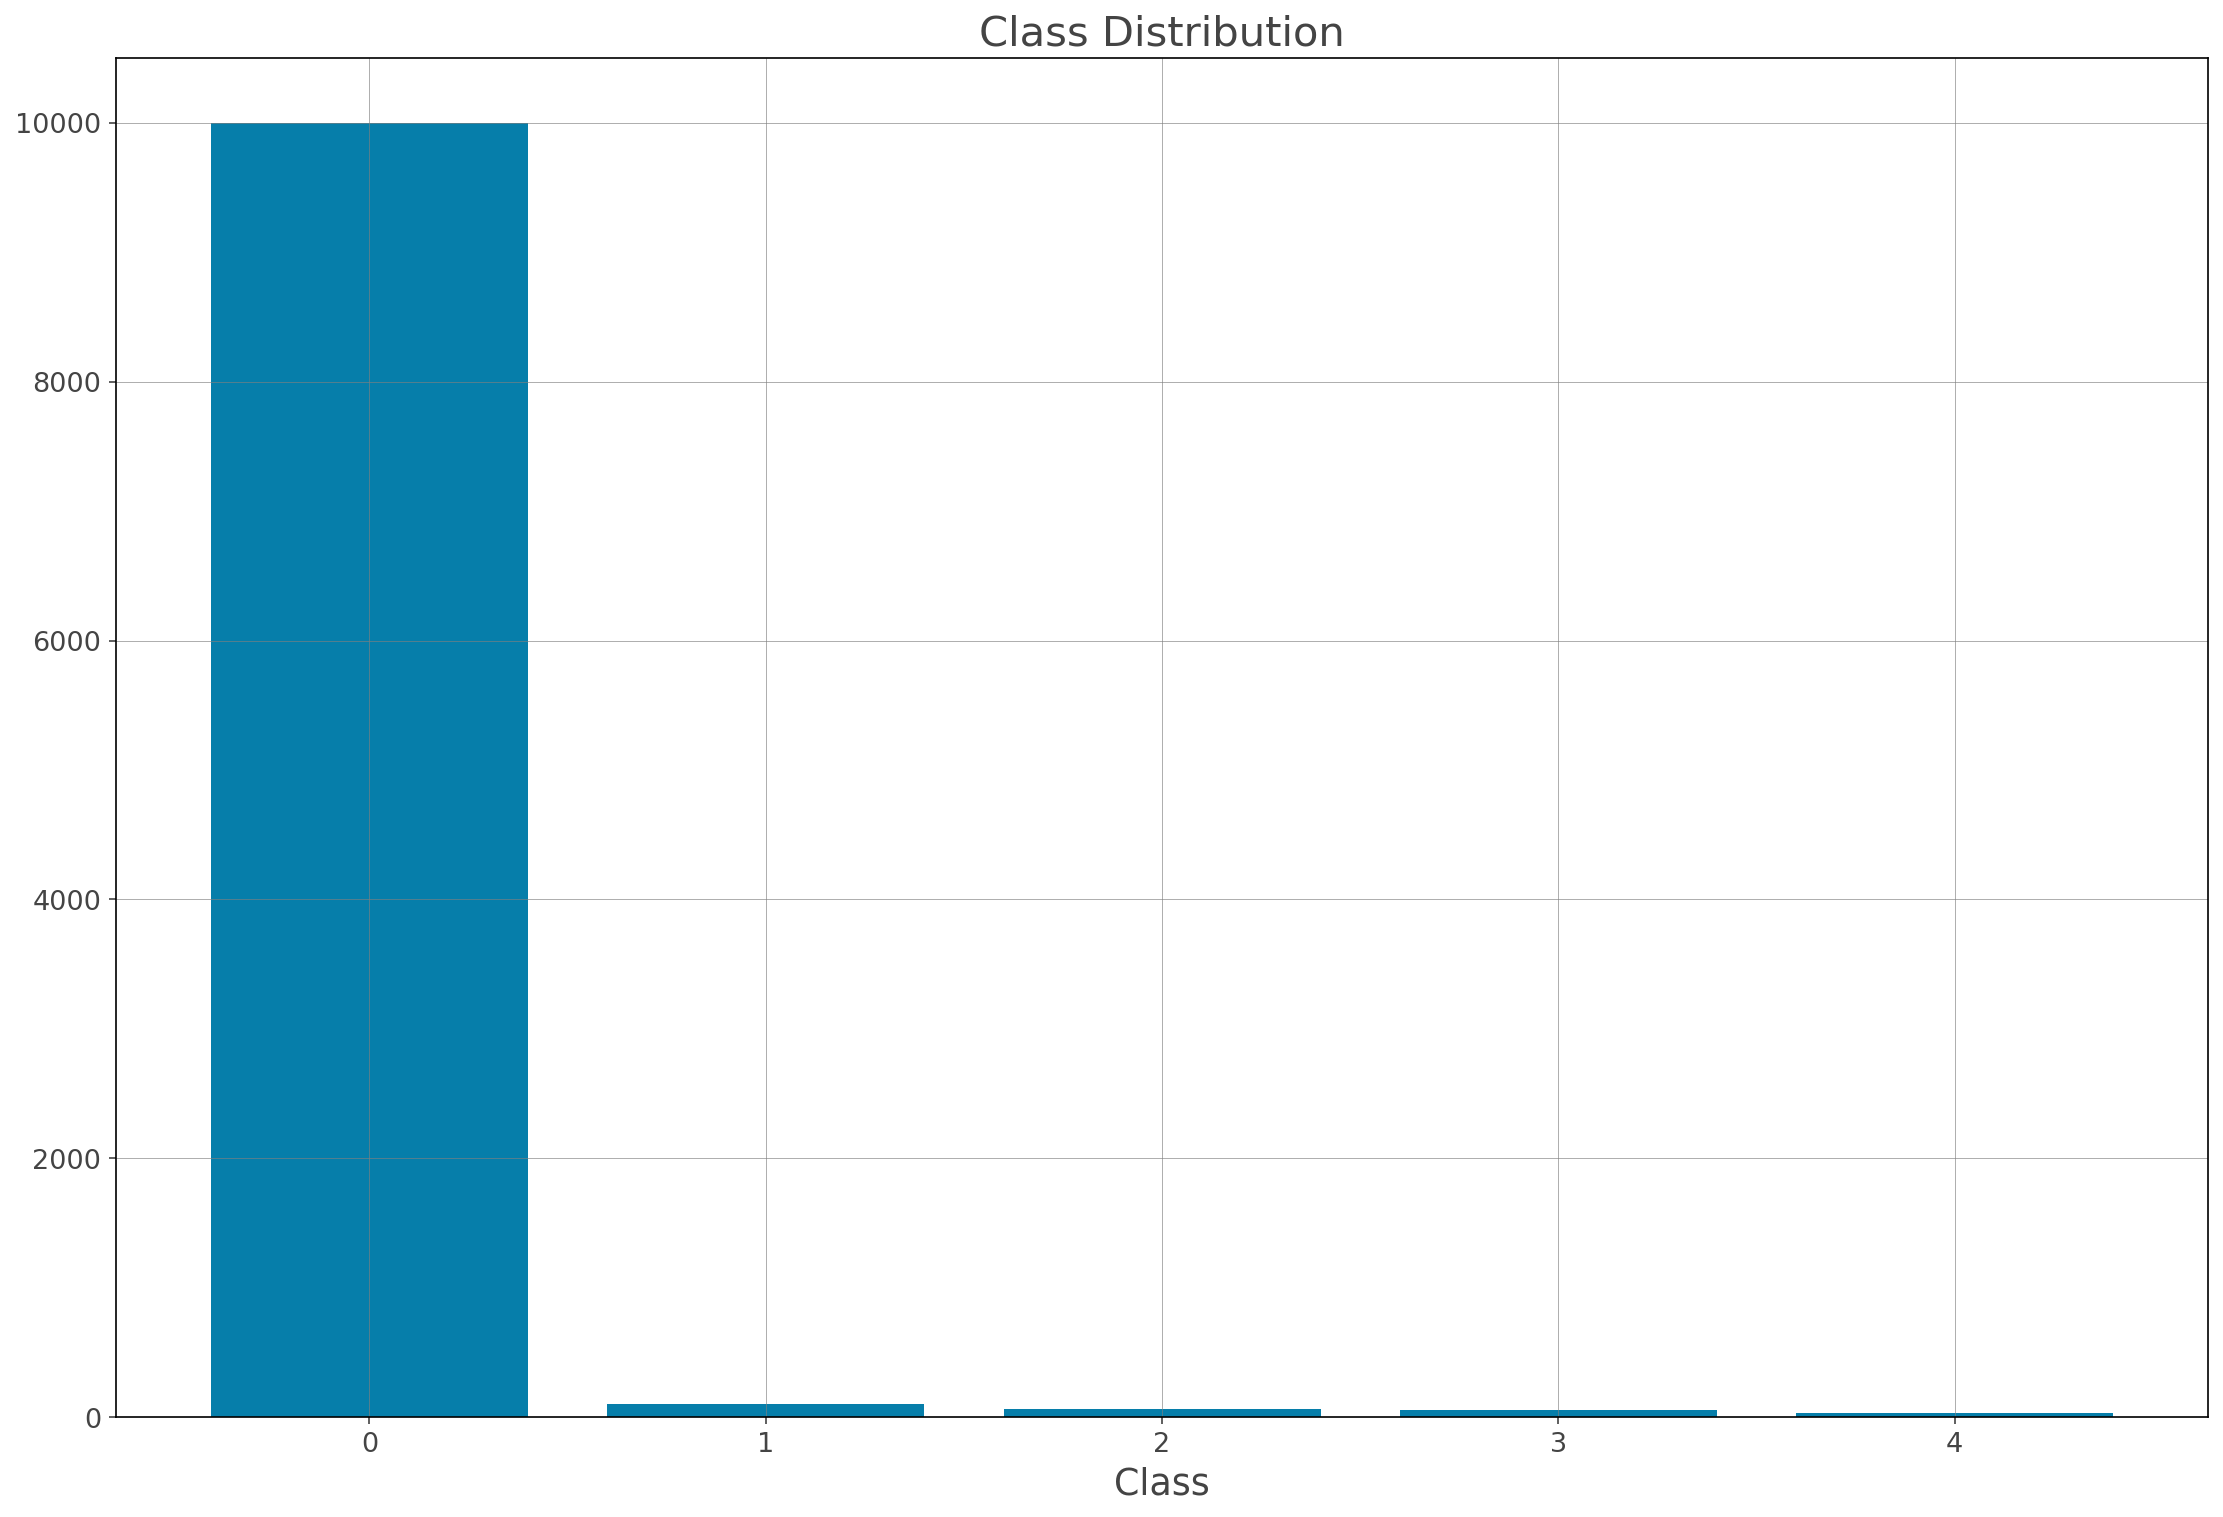

In [54]:
print('\nClass Distribution')
print('-----' * 25)
counter = Counter(y)
for classes, values in counter.items():
    per = values / len(y) * 100
    print('Class = %d \tn = %d   \t(%.3f%%)' % (classes, values, per))
print('-----' * 25)
    
    
unique, counts = np.unique(y, return_counts = True)
plt.bar(unique, counts)
plt.xlabel('Class')
plt.title('Class Distribution')


Class Distribution
-----------------------------------------------------------------------------------------------------------------------------
Class = 0 	n = 7999   	(20.000%)
Class = 1 	n = 7999   	(20.000%)
Class = 3 	n = 7999   	(20.000%)
Class = 2 	n = 7999   	(20.000%)
Class = 4 	n = 7999   	(20.000%)
-----------------------------------------------------------------------------------------------------------------------------


Text(0.5, 1.0, 'Class Distribution')

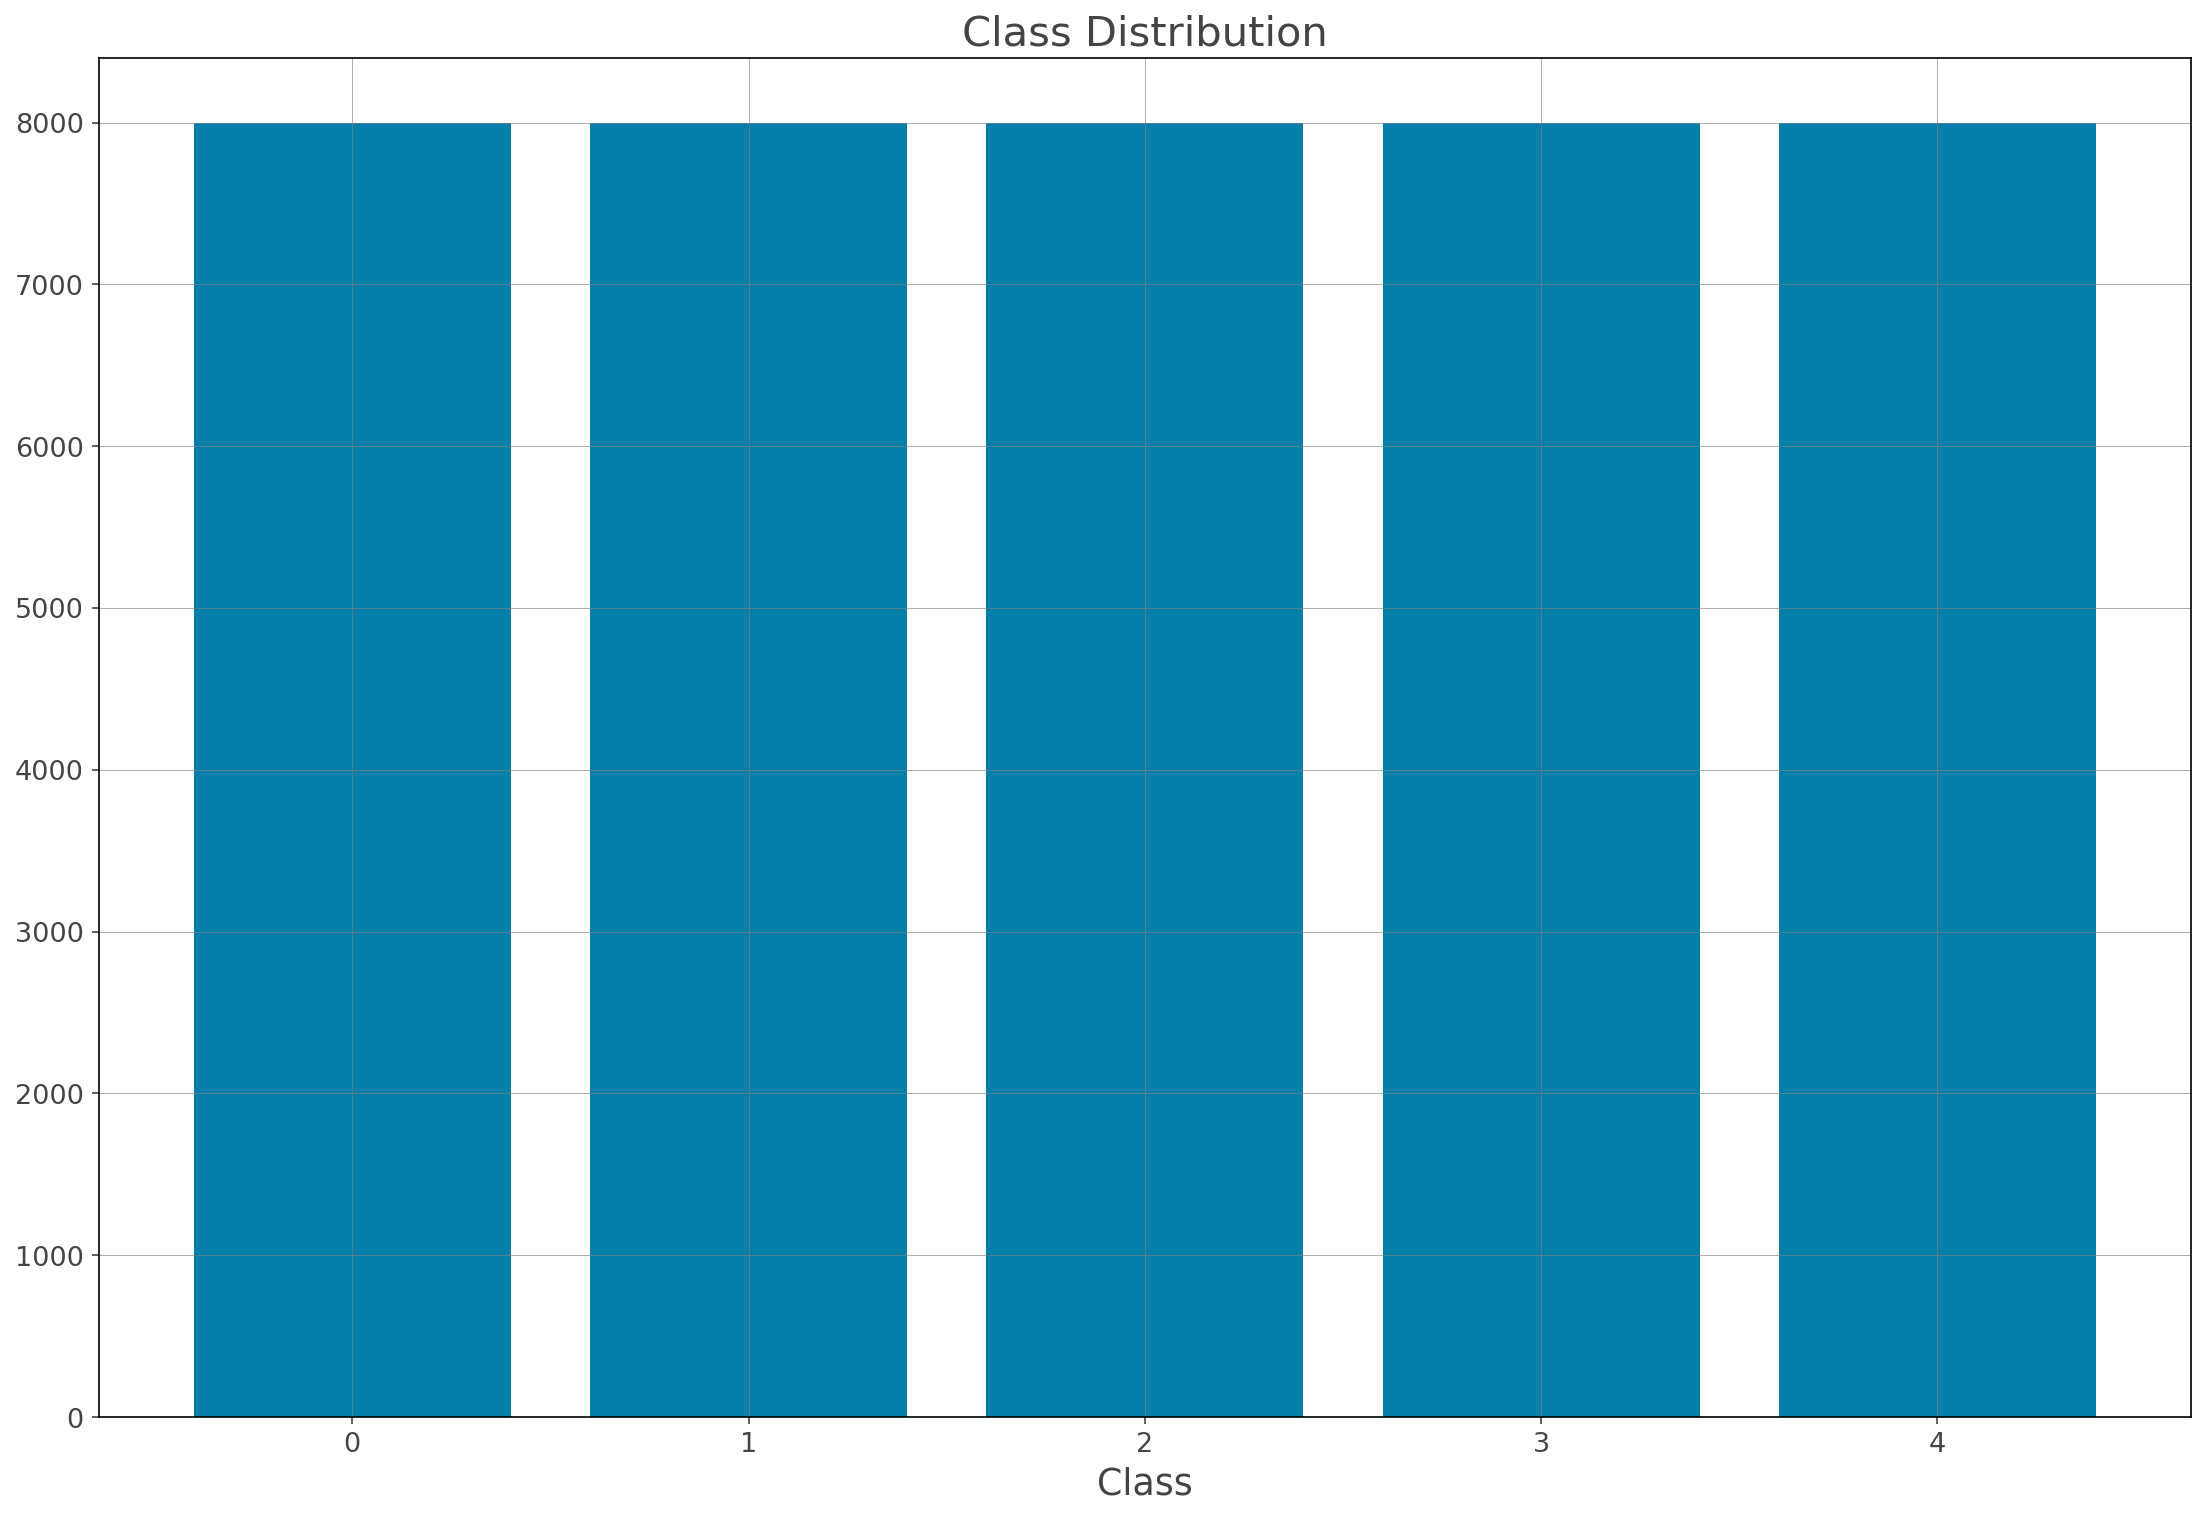

In [55]:
sm = SMOTE(random_state = 42)

x_train, y_train = sm.fit_resample(x_train, y_train)
    
print('\nClass Distribution')
print('-----' * 25)
counter = Counter(y_train)
for classes, values in counter.items():
    per = values / len(y_train) * 100
    print('Class = %d \tn = %d   \t(%.3f%%)' % (classes, values, per))
print('-----' * 25)
    
    
unique, counts = np.unique(y_train, return_counts = True)
plt.bar(unique, counts)
plt.xlabel('Class')
plt.title('Class Distribution')

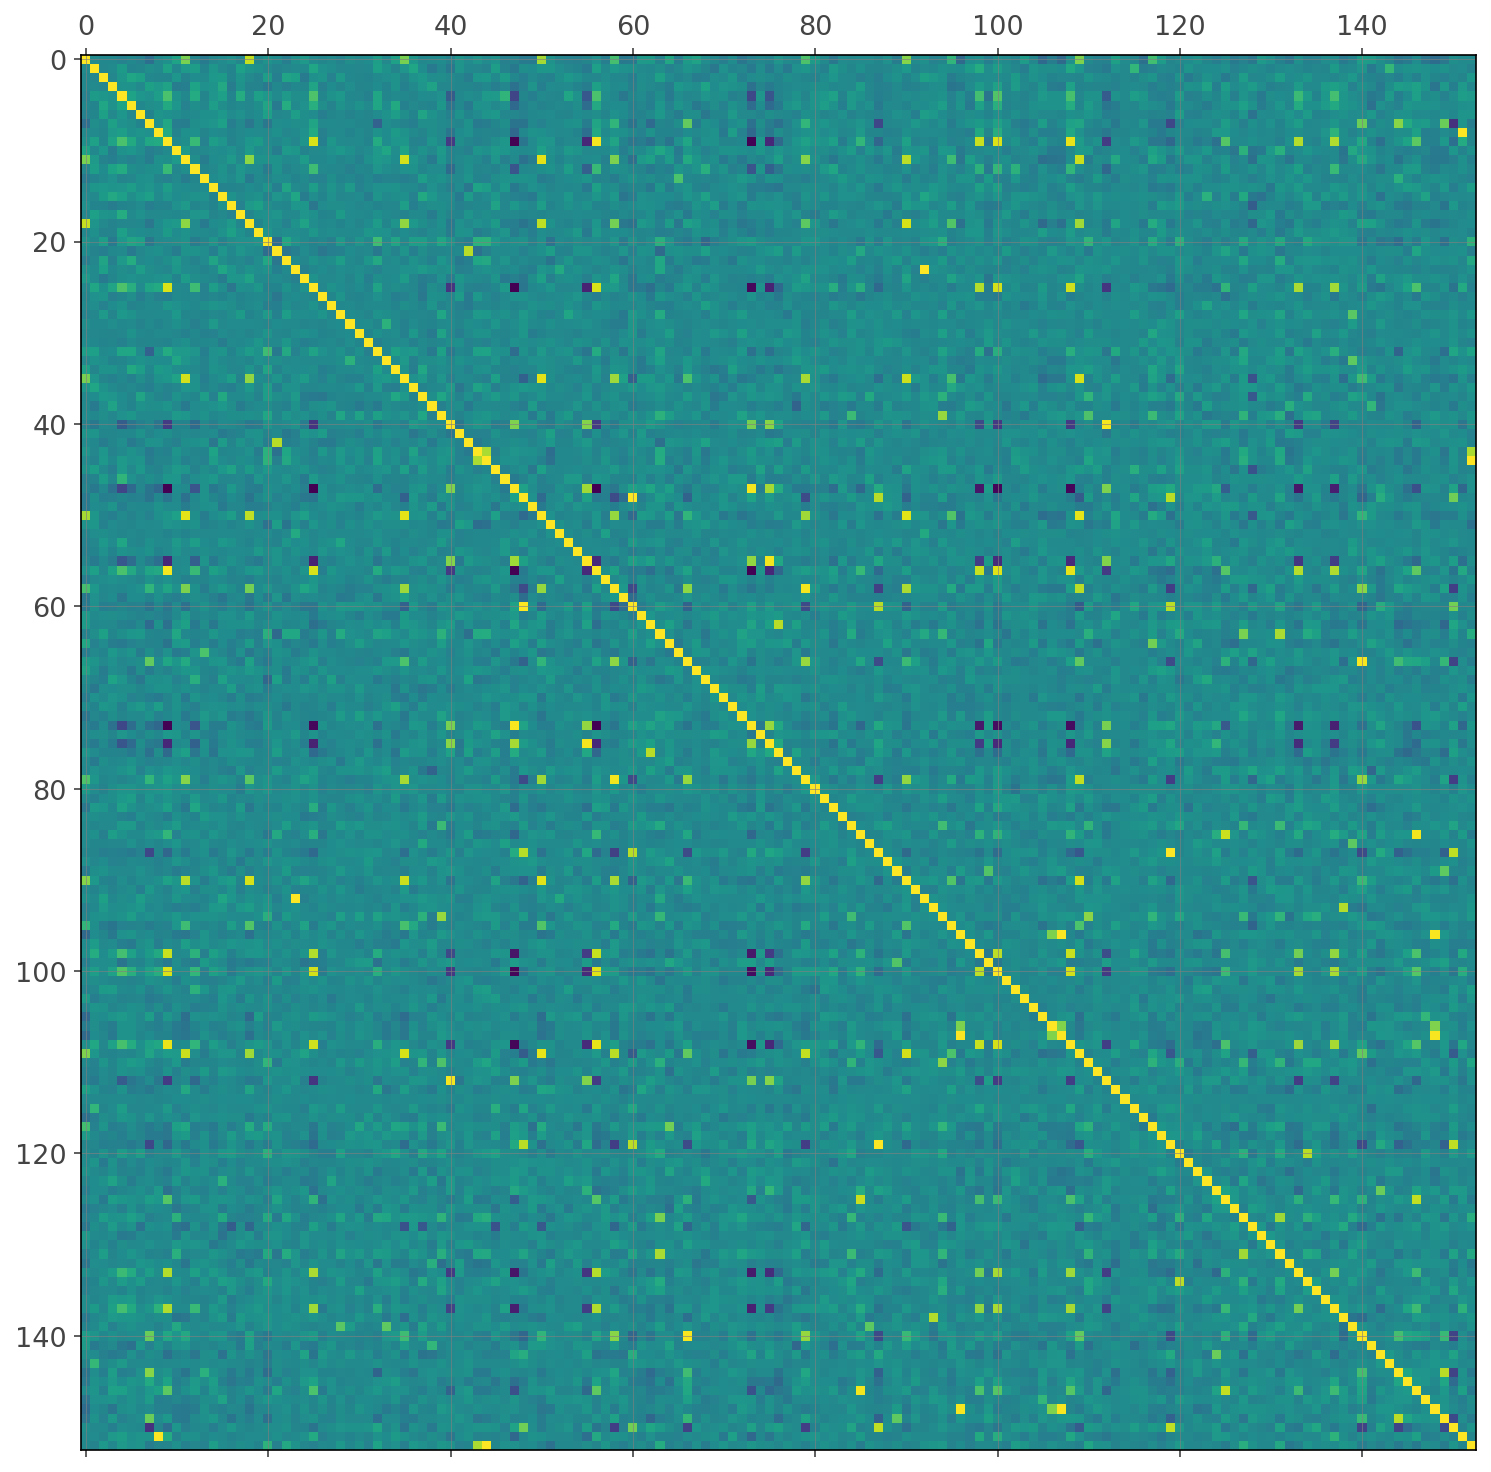

In [41]:
x_train_dst = pd.DataFrame(x_train)
x_train_dst_corr = x_train_dst.corr(method = 'pearson')
plt.matshow(x_train_dst_corr)

Side Note

-------------
1. Evidently, the Pearson Correlation Matrix showed improvement albeit being barely discernable.  
2. Imbalance Distribution of classes must be minimized as the produced model will have high biasness towards the most dominant class, producing 1 strong learner along with 4 weak learners due to insufficient exposure to the characteristics and signatures of the other minority classes.  
-------------

## Standardization

1. As per the previous notebook particularly the KDE and pair plot, it can be observed that most of the features exhibited a formation similar the generic Gaussian Distribution. 
2. As such, the Standard Scaler is chosen to center the mean around zero with a standard deviation of 1 as predictive models learn and generalize better under these conditions. 

In [24]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Model Training (Random Forest)

1. Random Forest Classifier is chosen for this task due to its intrinsic mathematical properties; an ensemble method at it's core.  
2. Other examples such as AdaBoost, XGBoost and Bagging has been decided against due to the ease of implementation of Random Forest Classifier.    
2. Such a model will definitely add value to a dataset with imbalance class distribution (remember our ultimate goal is to evaluate based on the real life TEST set!).  
3. In cases of imbalance class distribution for classification task, the F1 Score must also be taken into account.  
4. Optimum prediction power is hard to achieve due to the nature of the dataset in this case.  

In [132]:
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', class_weight = 'balanced', random_state = 42)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

Text(0.5, 176.08333333333331, 'Predicted Label')

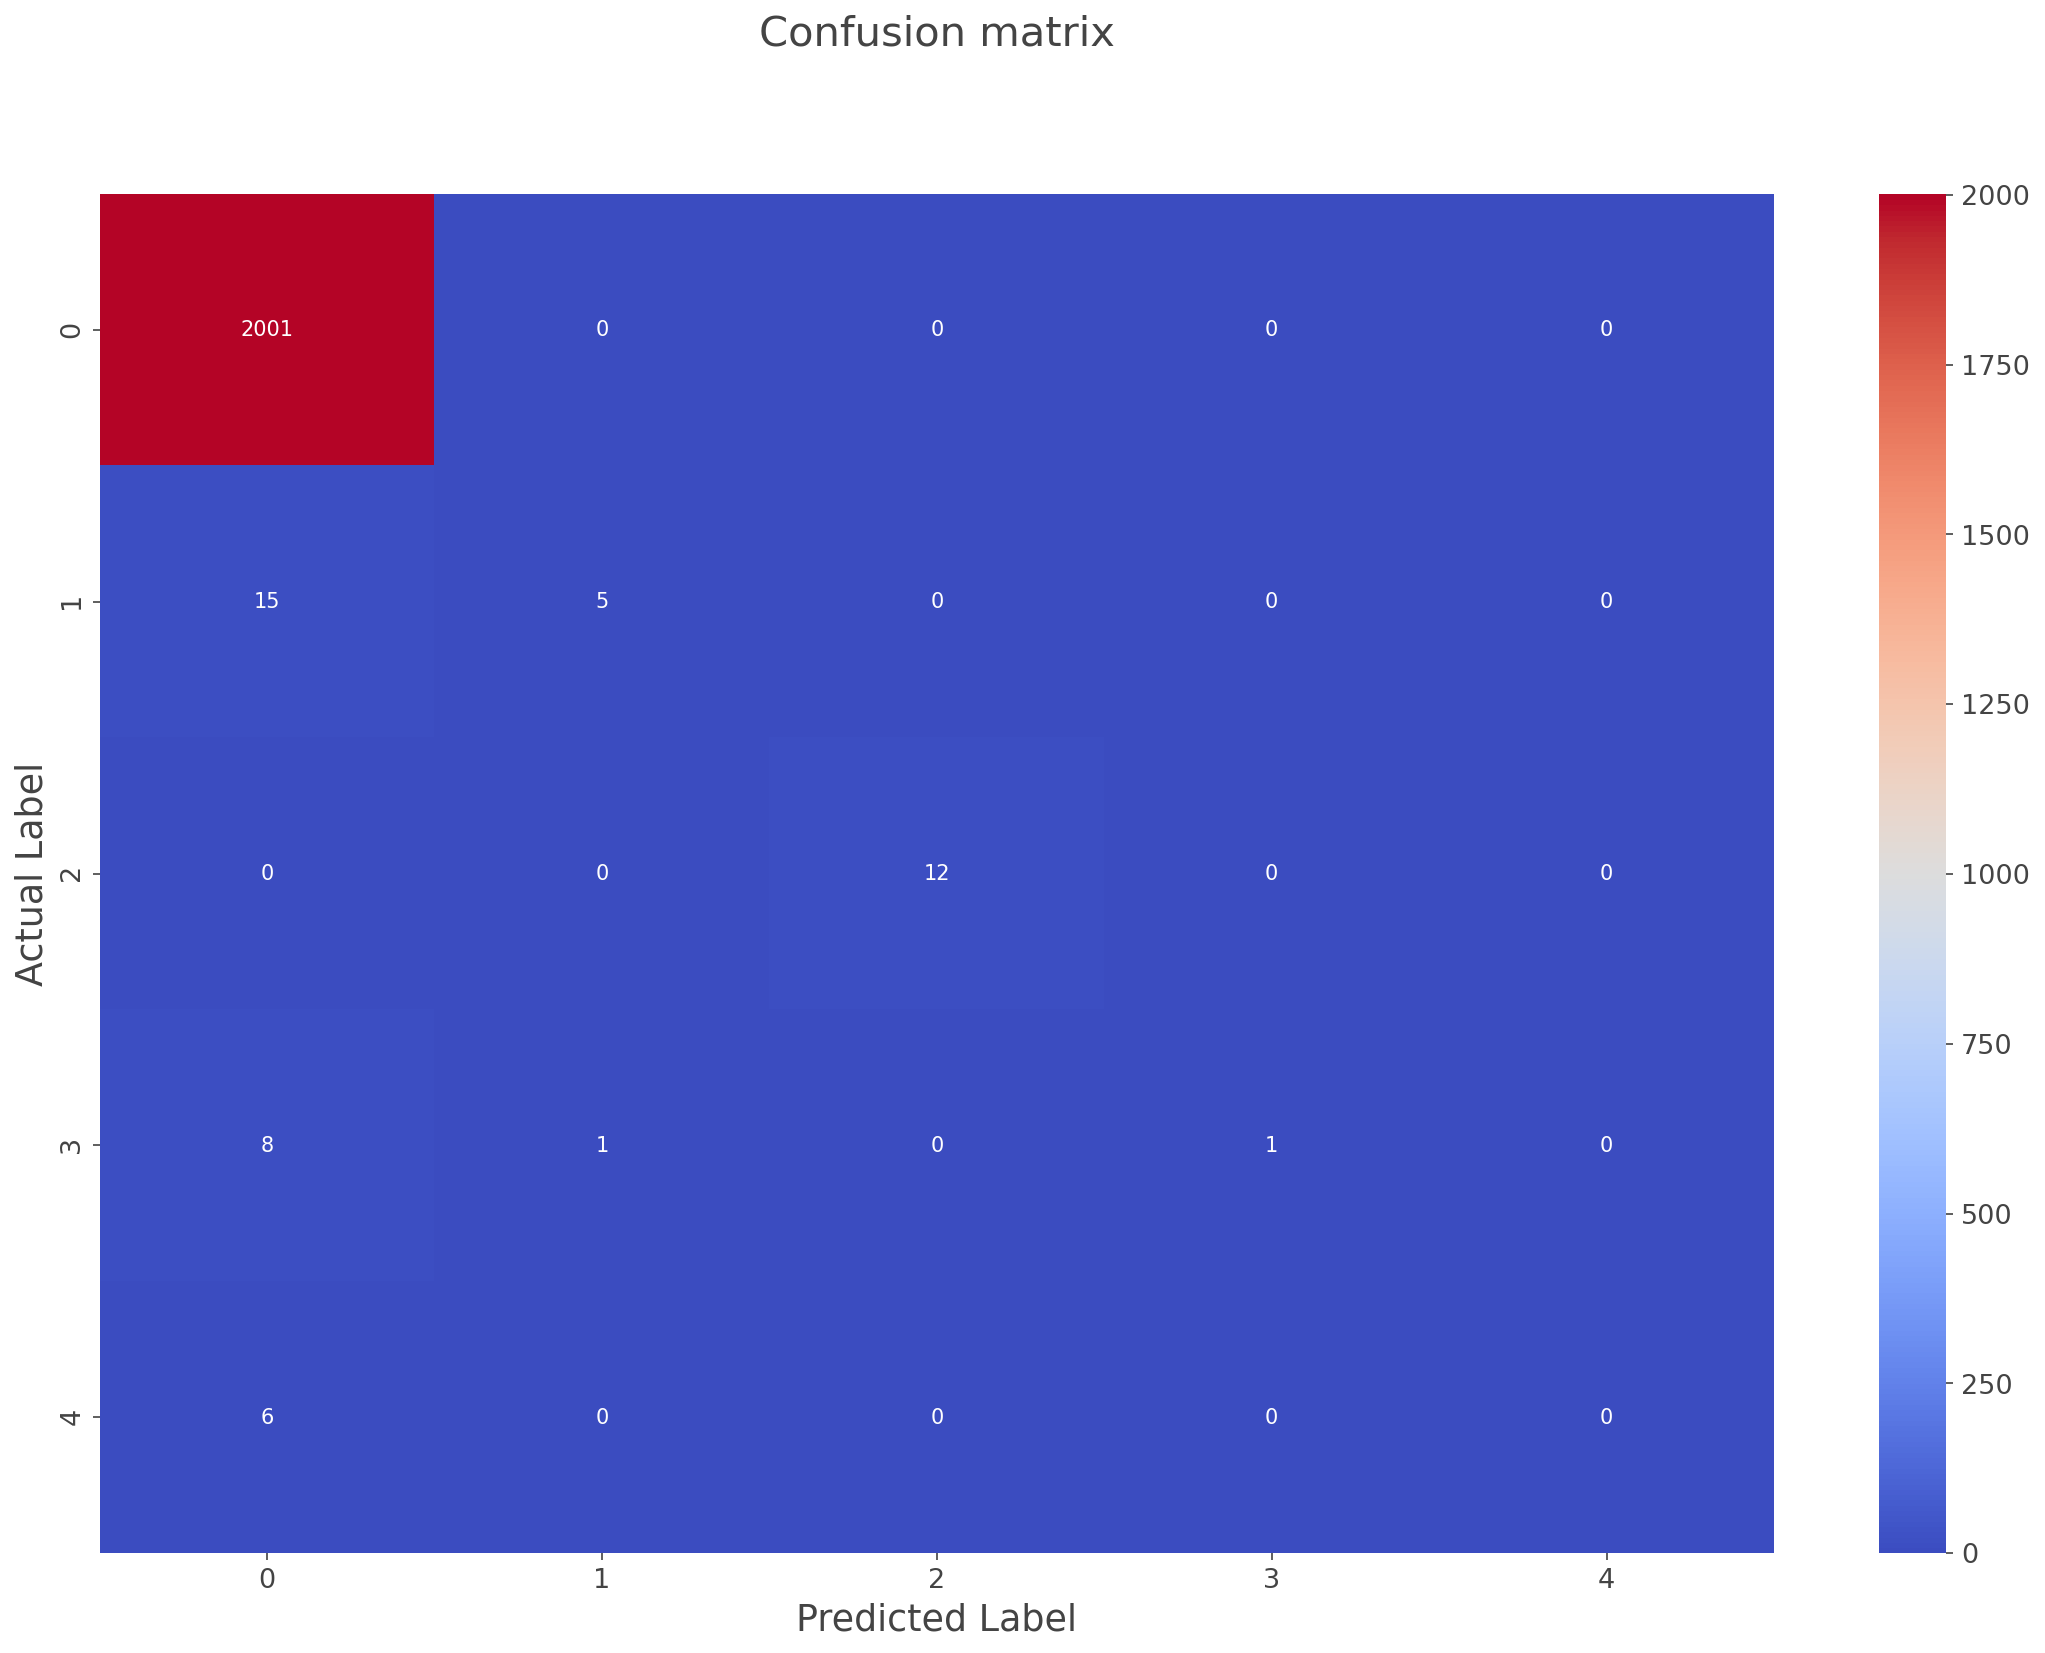

In [133]:
cm = confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap = "coolwarm" ,fmt = 'g')
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

In [134]:
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
accuracies.mean()
accuracies.std()

print('Prediction Results' )
print('-----' * 25)
print("Test Accuracy Score\t\t: ", accuracy_score(y_test, y_pred))
print("Cross-Validation accuracy score\t: ", accuracies.mean(), '\t[{}]'.format(accuracies.std()))
print("Test F1 Score\t\t\t: ", f1_score(y_test, y_pred, average = 'weighted'))
print('-----' * 25)
print('\n\n')
print(classification_report(y_test, y_pred))

Prediction Results
-----------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score		:  0.9853587115666179
Cross-Validation accuracy score	:  0.9998999812453112 	[0.00016586705390720792]
Test F1 Score			:  0.9800462694276486
-----------------------------------------------------------------------------------------------------------------------------



              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2001
           1       0.83      0.25      0.38        20
           2       1.00      1.00      1.00        12
           3       1.00      0.10      0.18        10
           4       0.00      0.00      0.00         6

    accuracy                           0.99      2049
   macro avg       0.76      0.47      0.51      2049
weighted avg       0.98      0.99      0.98      2049



# Hyperparameter Tuning (Randomized Search)

1. Improving the performance of the model through Hyperparameter Tuning through means of Randomized Search.

In [114]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [120]:
rfc = RandomForestClassifier()
rfc_random = RandomizedSearchCV(estimator = rfc, 
                                param_distributions = random_grid, 
                                n_iter = 100, 
                                cv = 3, 
                                verbose=2, 
                                random_state=42, 
                                n_jobs = -1)

rfc_random.fit(x_train, y_train)
rfc_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 157,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [129]:
classifier = RandomForestClassifier(n_estimators = 157,
                                    min_samples_split = 5,
                                    min_samples_leaf = 2,
                                    max_features = 'sqrt',
                                    max_depth = 90, 
                                    bootstrap = 'False',
                                    criterion = 'entropy', 
                                    class_weight = 'balanced', 
                                    random_state = 42)

classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

Text(0.5, 176.08333333333331, 'Predicted Label')

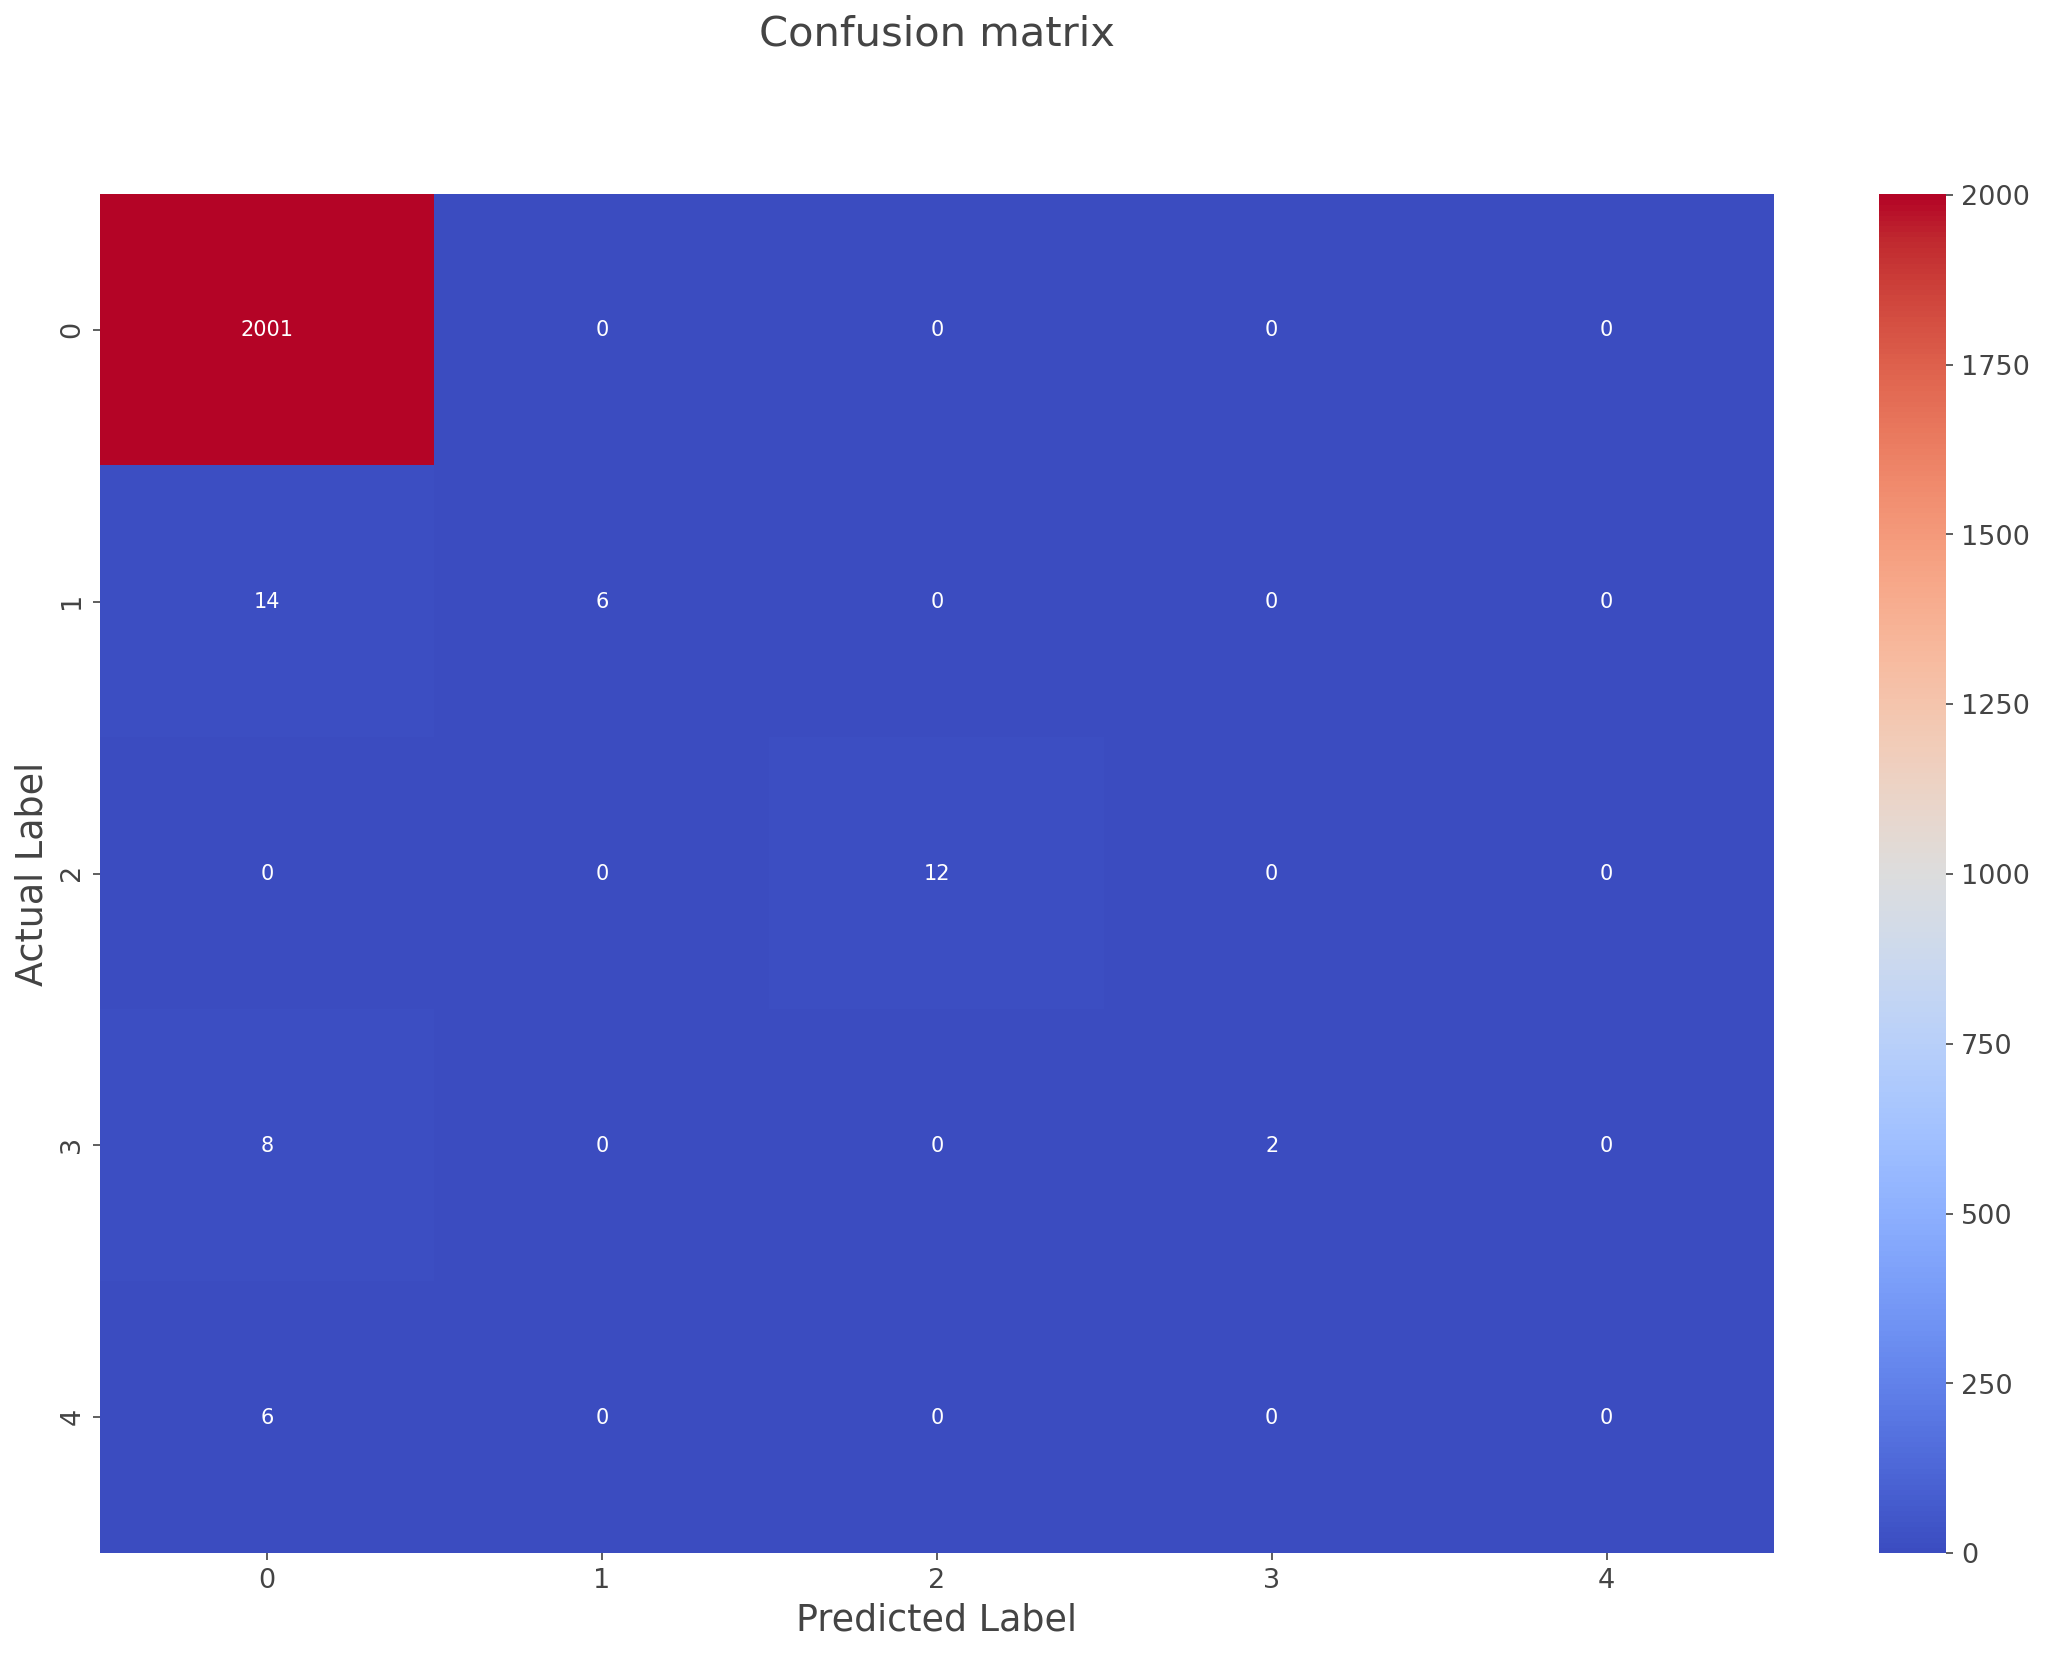

In [130]:
cm = confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap = "coolwarm" ,fmt = 'g')
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

In [131]:
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
accuracies.mean()
accuracies.std()

print('Prediction Results' )
print('-----' * 25)
print("Test Accuracy Score\t\t: ", accuracy_score(y_test, y_pred))
print("Cross-Validation accuracy score\t: ", accuracies.mean(), '\t[{}]'.format(accuracies.std()))
print("Test F1 Score\t\t\t: ", f1_score(y_test, y_pred, average = 'weighted'))
print('-----' * 25)
print('\n\n')
print(classification_report(y_test, y_pred))

Prediction Results
-----------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score		:  0.9863347974621767
Cross-Validation accuracy score	:  0.9998749874968741 	[0.00012501250500151562]
Test F1 Score			:  0.9817771464302423
-----------------------------------------------------------------------------------------------------------------------------



              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2001
           1       1.00      0.30      0.46        20
           2       1.00      1.00      1.00        12
           3       1.00      0.20      0.33        10
           4       0.00      0.00      0.00         6

    accuracy                           0.99      2049
   macro avg       0.80      0.50      0.56      2049
weighted avg       0.98      0.99      0.98      2049



# Conclusion

1. The model generally returned a marginally satisfactory predictive power due to it's painfully evident over-fitting.  
2. From the confusion matrix, we can see the model is biased and over-fitted towards CLASS A as we predicted.  
3. The model was NOT able to identify any of the CLASS E instances.
4. Albeit having high Accuracy score and satisfactory F1 score, there's still plenty of room for further improvement.  
5. It could've been improved further with stacked learners in an attempt to minimize the over-fitting issue.  

# Flight of Fancy(Hierachical Clustering)

In [36]:
x_hier = np.transpose(x_train)
y = pdist(x_hier)
z = sch.linkage(y, method = 'ward', metric = 'euclidean')

In [37]:
output_hc = sch.dendrogram(z)
plt.close()
outperm = np.asarray(output_hc['leaves'])
outperm = outperm.reshape((-1, 1))
outperm = outperm.transpose()

Text(0.5, 1.0, 'Dendrogram')

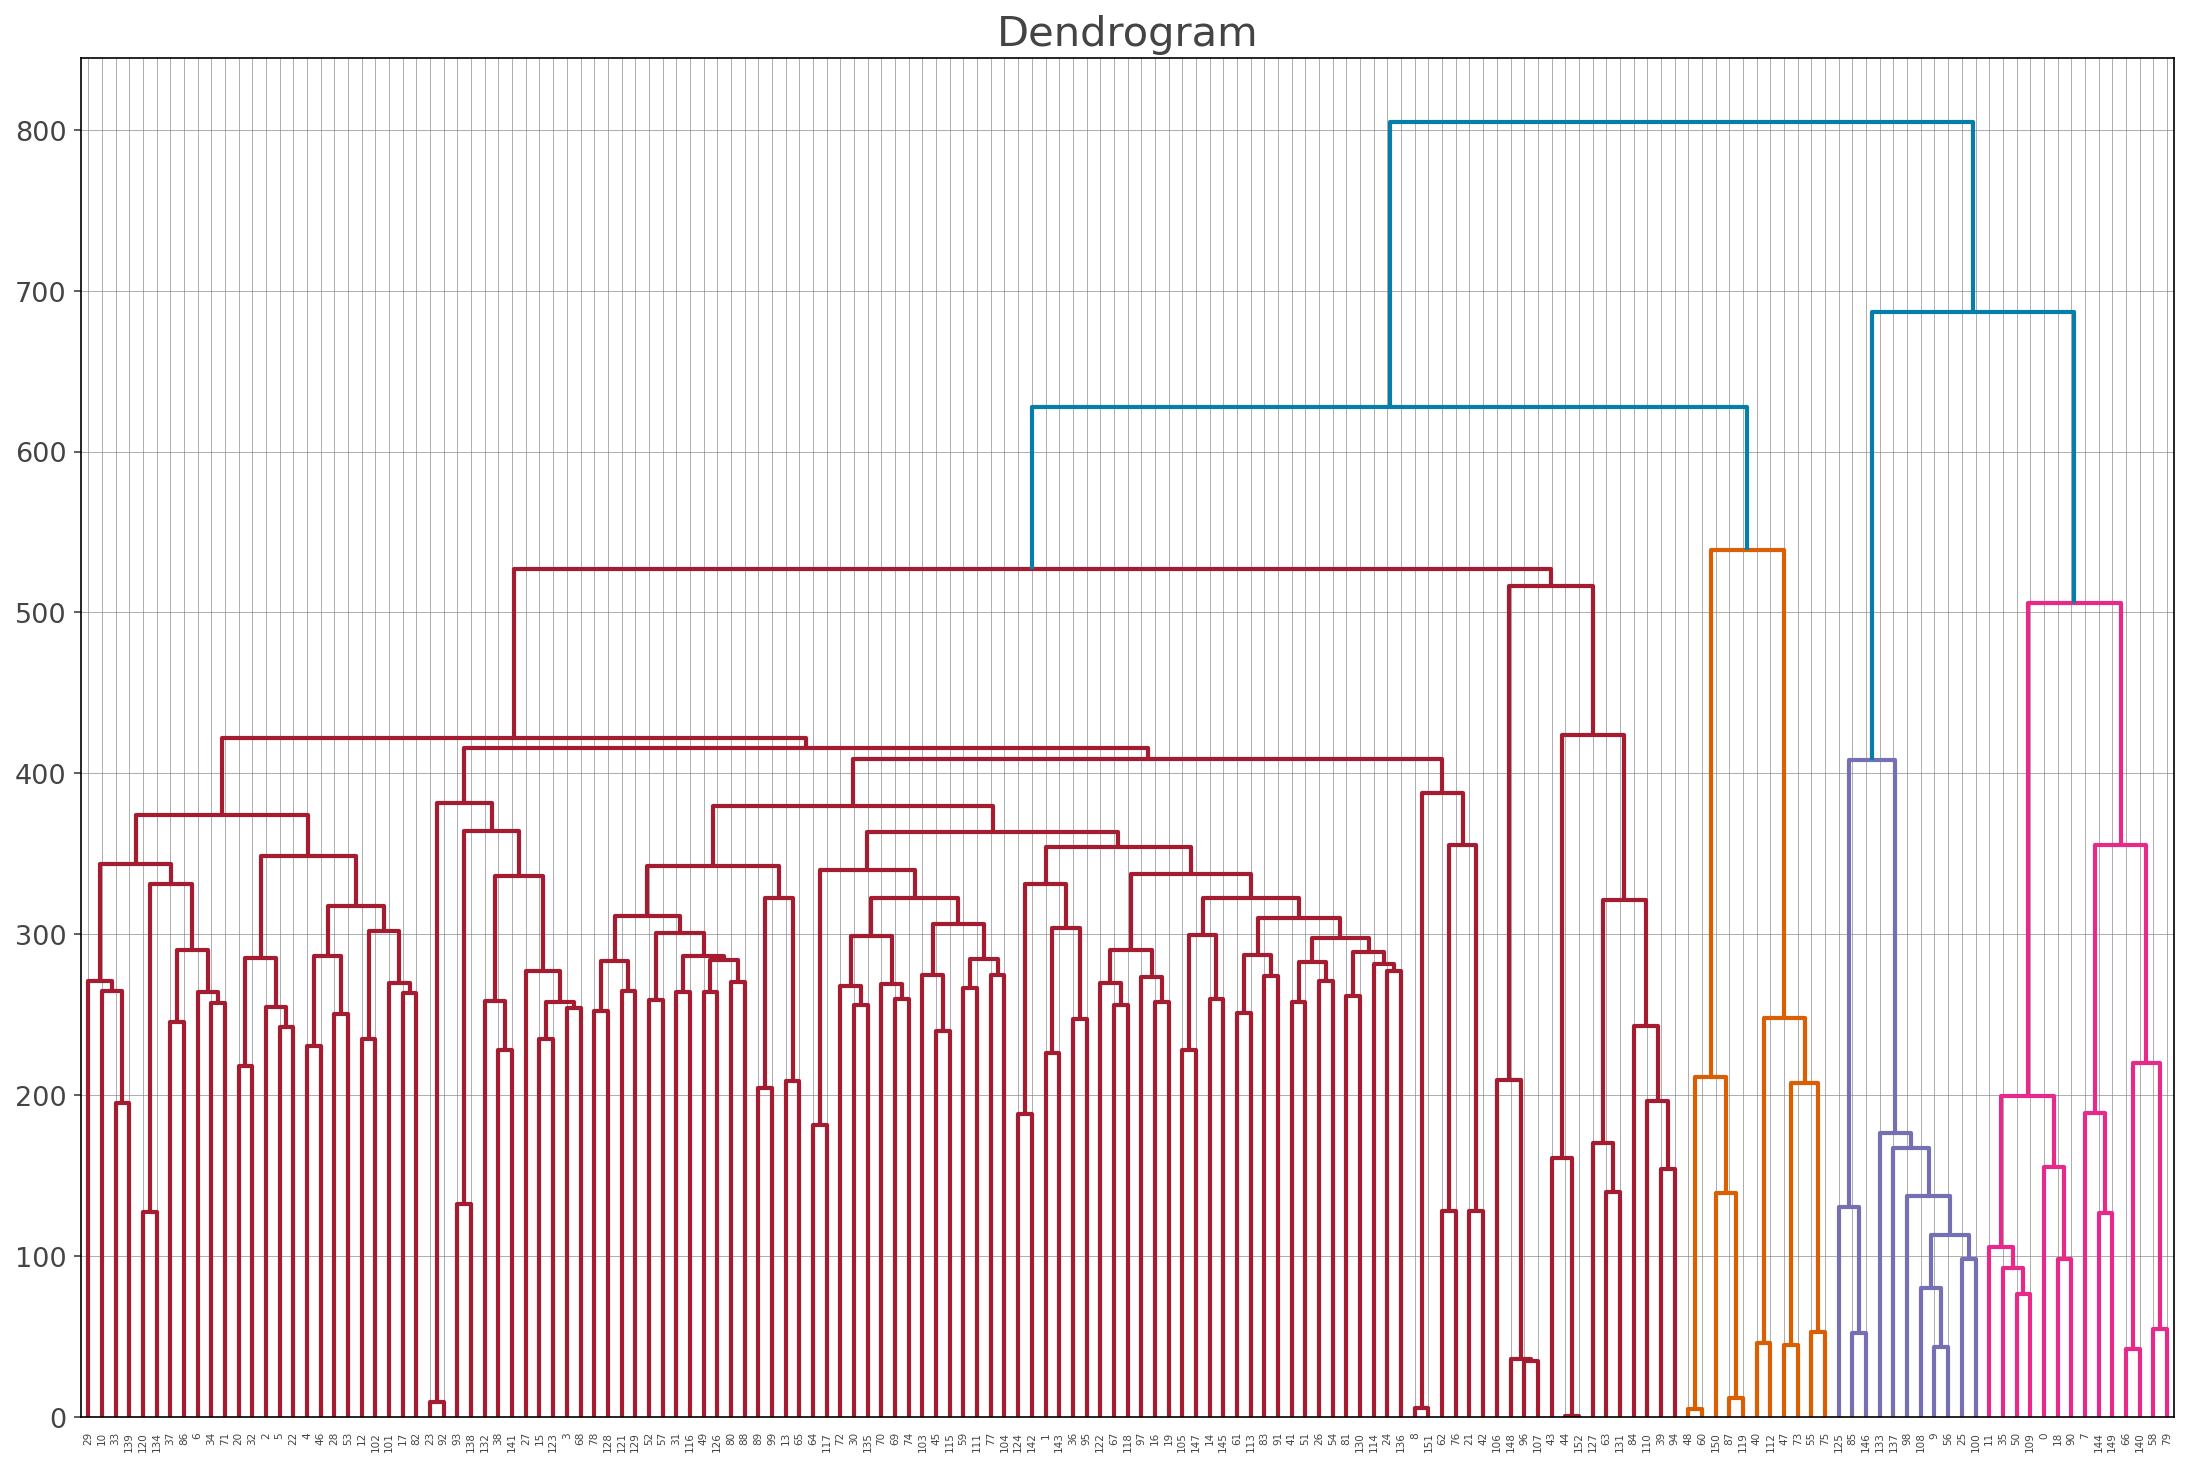

In [38]:
output_hc = sch.dendrogram(z)
plt.title("Dendrogram")  

1. A hidden piece if crucial info lies within the mangrove branches of the dendrogram representing the Euclidean distances between the Features as suspected but of which I shall'nt disclose.